# Random numbers

In this notebook, we will see how to generate random numbers in JAX. We will see how to generate pseudo random numbers from different distributions and how to set the seed for reproducibility. Finally, we will see how one might implement the [Barnsley fern](https://en.wikipedia.org/wiki/Barnsley_fern) fractal using random numbers in JAX.

## Summary

JAX provides the `jax.random` module to generate random numbers. The random number generation is by default deterministic, and is handled explicitly through `jax.random.PRNGKey` objects.

## Basic operations

When working with pseudo random numbers, we firstly need to set the initial seed.

In [1]:
from jax import random

key = random.key(2002)

This key then needs to be passed around to the functions that require random numbers. This is done to ensure reproducibility.

In [2]:
x = random.normal(key, (5,))
x

Array([ 1.0356433 , -0.53641194, -1.148886  , -1.5282793 , -1.3105366 ],      dtype=float32)

Be careful to not use the same key multiple times, as this will lead to the same random numbers being generated.

In [3]:
new_x = random.normal(key, (5,))
new_x

Array([ 1.0356433 , -0.53641194, -1.148886  , -1.5282793 , -1.3105366 ],      dtype=float32)

What we instead need to do is to split the key into two keys, one for the later generations, and one for the next random operation. An important rule is therefore to **never use the same key twice**.

In [4]:
key, subkey = random.split(key)
x = random.normal(subkey, (5,))

key, subkey = random.split(key)
new_x = random.normal(subkey, (5,))

x, new_x

(Array([-0.08093634, -2.1200354 , -0.18590307, -0.6793903 ,  0.89836293],      dtype=float32),
 Array([-0.55392116, -0.09915034,  0.27612254, -0.8496734 ,  1.2846861 ],      dtype=float32))

### Comparing with NumPy

In NumPy, we would use the `numpy.random` module to generate random numbers. This module relies on a global state, which means that we do not need to pass around a key explicitly. This is a very convenient feature, which might make it hard to understand why JAX does not have this feature.

The reason for this design choice is that this approach is not thread-safe, and can lead to non-deterministic results when running on multiple devices. As JAX is designed to be used in a distributed setting, this is a trade-off that has been made.

(MRN-random_numbers)=
### Multiple random numbers

As splitting individual keys can quickly become cumbersome, JAX provides a few convenience functions to generate multiple keys at once. We can for example use `jax.random.split` to generate multiple keys from a single key.

In [5]:
key, subkey_1, subkey_2 = random.split(key, 3)
key, *forty_two_subkeys = random.split(key, 43)

When we wish to generate a stream of random numbers, we can use the `jax.random.fold_in` function to generate a new key from an existing key, and some data.

In [6]:
weights = []
sizes = [2, 3, 3, 3, 1]
for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
    key = random.fold_in(key, i)
    weights.append(random.normal(key, (out_size, in_size)))

weights

[Array([[ 0.9550572 ,  0.3690654 ],
        [ 0.8450055 , -1.4974629 ],
        [-1.5337907 ,  0.21930021]], dtype=float32),
 Array([[-0.17976925,  0.11807024, -0.86824244],
        [-1.156412  , -2.4273913 , -0.17246407],
        [-0.44153085, -0.9143774 , -1.0624297 ]], dtype=float32),
 Array([[ 1.6268486 , -0.92591506, -0.6318233 ],
        [ 1.6806884 , -0.08871731,  1.2352027 ],
        [ 0.0449741 ,  0.6313606 , -0.5725324 ]], dtype=float32),
 Array([[0.61517316, 0.25676048, 2.019732  ]], dtype=float32)]

## Barnsley fern

The Barnsley fern is a fractal named after the British mathematician Michael Barnsley. It is constructed using a set of four affine transformations. The transformations are chosen randomly with probabilities $p_1, p_2, p_3, p_4$. The Barnsley fern is a self-similar fractal, meaning that it is made up of smaller copies of itself. The fern is constructed by starting at the origin and applying one of the four transformations at random. This process is repeated many times to generate the fern.

The four transformations are:
```{math}
\begin{array}{|c|c|c|l|}
    w & \text{Transformation} & \text{Probability} & \text{Portion generated} \\ \hline
    f_1 & \begin{bmatrix} 0 & 0 \\ 0 & 0.16 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} & 0.01 & \text{Stem} \\
    f_2 & \begin{bmatrix} 0.85 & 0.04 \\ -0.04 & 0.85 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 0 \\ 1.60 \end{bmatrix} & 0.85 & \text{Successively smaller leaflets} \\
    f_3 & \begin{bmatrix} 0.20 & -0.26 \\ 0.23 & 0.22 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 0 \\ 1.60 \end{bmatrix} & 0.07 & \text{Largest left-hand leaflet} \\
    f_4 & \begin{bmatrix} -0.15 & 0.28 \\ 0.26 & 0.24 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 0 \\ 0.44 \end{bmatrix} & 0.07 & \text{Largest right-hand leaflet} \\
\end{array}
```

We begin by implementing the set of transformations.

In [7]:
import jax.numpy as jnp
from jax import Array
from typing import NamedTuple


class BarnsleyFern(NamedTuple):
    Ws: Array
    bs: Array
    probabilities: Array = jnp.array([0.01, 0.85, 0.07, 0.07])


def setup_transformations() -> BarnsleyFern:
    W1 = jnp.array([[0.0, 0.0], [0.0, 0.16]])
    b1 = jnp.array([0.0, 0.0])

    W2 = jnp.array([[0.85, 0.04], [-0.04, 0.85]])
    b2 = jnp.array([0.0, 1.6])

    W3 = jnp.array([[0.2, -0.26], [0.23, 0.22]])
    b3 = jnp.array([0.0, 1.6])

    W4 = jnp.array([[-0.15, 0.28], [0.26, 0.24]])
    b4 = jnp.array([0.0, 0.44])

    Ws = jnp.stack([W1, W2, W3, W4])
    bs = jnp.array([b1, b2, b3, b4])

    return BarnsleyFern(Ws, bs)

We pick the desired function by sampling a random number $p \in [0, 1]$, and then choosing the last transformation $f_i$ such that $p < \sum_{i=1}^n p_i$.

In [8]:
def pick_function(p: Array, cumul_prob: Array) -> int:
    return jnp.argmax(p < cumul_prob)

In order to get efficient looping, we will use `jax.lax.scan` to apply the transformations multiple times. This is because the next point depends on the previous point, and we cannot parallelize the computation.

`scan` is roughly equivalent with the following Python code:
```{code} python
:caption: Python equivalent of `jax.lax.scan`, from the [JAX documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html)
def scan(f, init, xs, length=None):
    if xs is None:
        xs = [None] * length
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)
        ys.append(y)
    return carry, ys
```

Within `f`, we define the inner loop logic. This function is automatically jitted by JAX, so we do not need to worry about that.

In [9]:
from jax import random, lax


def barnsley_fern(
    key: Array,
    n_points: int,
    fern: BarnsleyFern = None,
) -> Array:
    if fern is None:
        fern = setup_transformations()

    cumul_prob = jnp.cumsum(fern.probabilities)

    Ws, bs = fern.Ws, fern.bs

    def inner_loop(
        carry: tuple[Array, Array], x: Array
    ) -> tuple[tuple[Array, Array], Array]:
        key, x0 = carry
        key, subkey = random.split(key)
        p = random.uniform(subkey)

        i = pick_function(p, cumul_prob)
        W = Ws[i]
        b = bs[i]

        new_x = W @ x0 + b

        return (key, new_x), new_x

    init = (key, jnp.zeros(2))
    _, points = lax.scan(inner_loop, init, xs=None, length=n_points)

    return points

Then, to generate the fern, we simply need to choose the desired number of points and the initial seed.

In [10]:
key = random.key(2002)
n_points = 1000000

points = barnsley_fern(key, n_points)

Finally, we can plot the fern using `matplotlib`, in order to visualize the fractal.

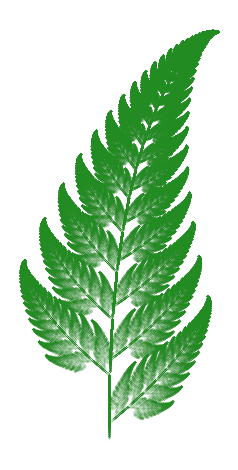

In [11]:
import matplotlib.pyplot as plt


plt.scatter(
    points[:, 0], points[:, 1], marker=".", s=0.01, alpha=0.4, color="forestgreen"
)
plt.axis("scaled")
plt.axis("off")
plt.tight_layout()
# plt.savefig("../figures/barnsley_fern.png", dpi=300, transparent=True)
plt.show()